# Stable Diffusion Tutorial for AI Course (Feb 19, 2024)

Stable Diffusion is a text-to-image latent diffusion model. In this tutorial, we explorer how to setup the environment to run Stable Diffusion with the [Diffusers library](https://github.com/huggingface/diffusers).

Reference:
[Understanding pipelines, models and schedulers
](https://huggingface.co/docs/diffusers/en/using-diffusers/write_own_pipeline)

In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [ ]:
!pip install diffusers
!pip install transformers accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.3 MB/s eta 0:00:00


In [1]:
import sys
import torch
from PIL import Image


if sys.platform == "darwin":
    # MacOS
    device = torch.device("mps")
    torch_dtype = torch.float32
elif torch.cuda.is_available():
    device = torch.device("cuda")
    torch_dtype = torch.float16
else:
    device = torch.device("cpu")
    torch_dtype = torch.float32
print("Device:", device)

# Define utility function
def image_grid(imgs, rows, cols):
    # Generate an image grid given the list of PIL images
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

Device: mps


In [2]:
from diffusers import StableDiffusionPipeline


# Load the Stable Diffusion pipeline from Diffusers library
pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    # "stabilityai/stable-diffusion-2-1",
    torch_dtype=torch_dtype
)
pipe = pipe.to(device)

pipe.enable_attention_slicing()

/opt/homebrew/Caskroom/miniconda/base/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:384: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)
/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.

### Parameters for Stable diffusion pipeline
- `prompt`
- `negative_prompt`
- `num_images_per_prompt`: The number of images for each prompt
- `num_inference_steps`: The number of diffusion steps used when generating samples
- `guidance_scale`: The guidance_scale parameter affects how much the prompt influences image generation. A lower value gives the model “creativity” to generate images that are more loosely related to the prompt. Higher guidance_scale values push the model to follow the prompt more closely, and if this value is too high, you may observe some artifacts in the generated image.

100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


(512, 512)


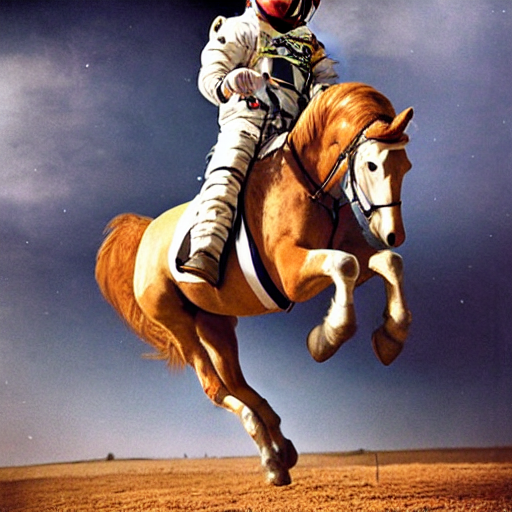

In [3]:
prompt = "a photograph of an astronaut riding a horse"
negative_prompt = "jpeg artifacts, low quality, artifacts"
num_images_per_prompt = 1
num_inference_steps = 20
guidance_scale = 7.5

generator = torch.manual_seed(1)

# Run the Stable diffusion pipeline!
images = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=num_inference_steps,
    num_images_per_prompt=num_images_per_prompt,
    guidance_scale=guidance_scale,
    generator=generator,
).images

print(images[0].size)

grid = image_grid(images, 1, num_images_per_prompt)
# Display the image
grid

Let's build our own StableDiffusion Pipeline!
We are going use the SD2.1 again. There are many important moudels to build a complete pipeline.

- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.
For SD2.1, we find find the pre-trained models files in [SD2.1 model files](https://huggingface.co/stabilityai/stable-diffusion-2-1/tree/main)

In [2]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, DDIMScheduler

load_path = "runwayml/stable-diffusion-v1-5"
# load_path = "stabilityai/stable-diffusion-2-1"

# Load the required models
vae = AutoencoderKL.from_pretrained(load_path, subfolder="vae", torch_dtype=torch_dtype).to(device)

tokenizer = CLIPTokenizer.from_pretrained(load_path, subfolder="tokenizer")

text_encoder = CLIPTextModel.from_pretrained(load_path, subfolder="text_encoder").to(device)

unet = UNet2DConditionModel.from_pretrained(load_path, subfolder="unet", torch_dtype=torch_dtype).to(device)

scheduler = DDIMScheduler.from_pretrained(load_path, subfolder="scheduler")

/opt/homebrew/Caskroom/miniconda/base/envs/diff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:300: FutureWarning: `LoRACompatibleConv` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleConv` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleConv", "1.0.0", deprecation_message)
/Users/jongyoo/Workspace/diffusers/src/diffusers/models/lora.py:384: FutureWarning: `LoRACompatibleLinear` is deprecated and will be removed in version 1.0.0. Use of `LoRACompatibleLinear` is deprecated. Please switch to PEFT backend by installing PEFT: `pip install peft`.
  deprecate("LoRACompatibleLinear", "1.0.0", deprecation_message)


We now define the parameters for image generation.

In [3]:
height = 512  # SD 2.1: 768 / SDXL: 1024
width = 512

prompt = ["a photograph of an astronaut riding a horse"]
negative_prompt = ["jpeg artifacts, low quality, artifacts"]
num_images_per_prompt = 1
num_inference_steps = 20
guidance_scale = 7.5

generator = torch.manual_seed(1)
batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [4]:
# Tokenize the text and generate the embeddings from the prompt
text_inputs = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
print(text_inputs.input_ids.shape)
# input_ids: List of token ids to be fed to a model.

with torch.no_grad():
    prompt_embeds = text_encoder(text_inputs.input_ids.to(device))
    prompt_embeds = prompt_embeds[0]

    bs_embed, seq_len, _ = prompt_embeds.shape
    print(bs_embed, seq_len)

    prompt_embeds = prompt_embeds.to(dtype=torch_dtype, device=device)
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

max_length = prompt_embeds.shape[1]
uncond_input = tokenizer(
    negative_prompt,
    padding="max_length",
    max_length=max_length,
    truncation=True,
    return_tensors="pt",
)

with torch.no_grad():
    negative_prompt_embeds = text_encoder(uncond_input.input_ids.to(device))
    negative_prompt_embeds = negative_prompt_embeds[0]

    seq_len = negative_prompt_embeds.shape[1]

    negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds.dtype, device=device)
    negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
    negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds])

print(prompt_embeds.shape)

torch.Size([1, 77])
1 77
torch.Size([2, 77, 768])


For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [5]:
latents = torch.randn(
    (batch_size * num_images_per_prompt, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(device)
print("latents shape:", latents.shape)

latents shape: torch.Size([1, 4, 64, 64])


/var/folders/yz/4wsq420d7mv8024lyh9jyb5h0000gn/T/ipykernel_75823/1539580931.py:2: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size * num_images_per_prompt, unet.in_channels, height // 8, width // 8),


Start by scaling the input with the initial noise distribution, sigma, the noise scale value

In [6]:
latents = latents * scheduler.init_noise_sigma

The last step is to create the denoising loop that’ll progressively transform the pure noise in latents to an image

In [7]:
from tqdm.auto import tqdm

# Set the scheduler’s timesteps to use during denoising.
# This will compute the `sigmas` and exact time step values to be used
# during the denoising process.
scheduler.set_timesteps(num_inference_steps, device=device)

with torch.no_grad():
    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=prompt_embeds,
            return_dict=False,
        )[0]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents, return_dict=False)[0]

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


We now use the `vae` to decode the generated `latents` back into the image.

In [8]:
# scale and decode the image latents with vae
# vae.config.scaling_factor = 0.18215 for SD 1.5
with torch.no_grad():
    image = vae.decode(1 / vae.config.scaling_factor * latents, return_dict=False, generator=generator)[0]

print(image.shape)

torch.Size([1, 3, 512, 512])


(1, 512, 512, 3)


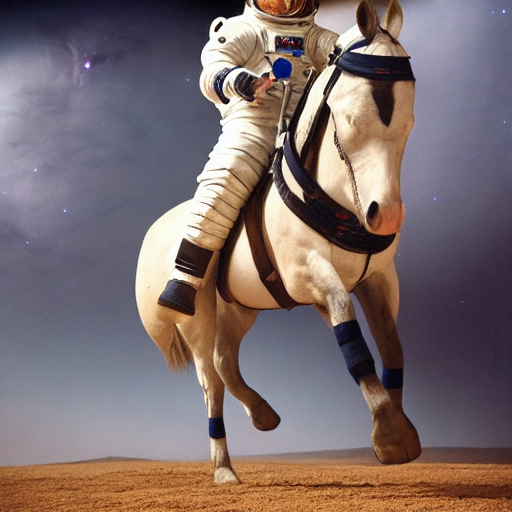

In [9]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

print(image.shape)

images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

grid = image_grid(pil_images, 1, num_images_per_prompt)

# Display the image
grid
